# Hard magnet tutorial

## Introduction

- In this notebook we explore hard magnet properties such as Hc as function of temperature for Fe16N2.
- We query databases to get temperature-dependent inputs for micromagnetic simulations from DFT and spin dynamics simulations
- We run hysteresis simulations and compute derived quantities.

Requirements:
- Software: `mammos`, `esys-escript`
- Basic understanding of [mammos-units](https://mammos-project.github.io/mammos/examples/mammos-units/quickstart.html) and [mammos-entity](https://mammos-project.github.io/mammos/examples/mammos-entity/quickstart.html)

The MODA diagram is provided at the bottom of the notebook.

In [1]:
%config InlineBackend.figure_format = "retina"

import math

import mammos_analysis
import mammos_dft
import mammos_entity as me
import mammos_mumag
import mammos_spindynamics
import mammos_units as u
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import colormaps

In [2]:
# Allow convenient conversions between A/m and T
u.set_enabled_equivalencies(u.magnetic_flux_field());

## DFT data: magnetization and anisotropy at zero Kelvin
The first step loads spontaneous magnetization `Ms_0` and the uniaxial anisotropy constant `K1_0` from a database of DFT calculations (at T=0K).

We can use the `print_info` flag to trigger printing of crystallographic information.

In [3]:
material = "Fe2.33Ta0.67Y"

results_dft = mammos_dft.db.get_micromagnetic_properties(material, print_info=True)

Found material in database.

Chemical Formula: Fe2.33Ta0.67Y
Space group name: 
Space group number: 0
Cell length a: 5.227483 Angstrom
Cell length b: 5.227483 Angstrom
Cell length c: 25.022642 Angstrom
Cell angle alpha: 90.0 deg
Cell angle beta: 90.0 deg
Cell angle gamma: 120.0 deg
Cell volume: 592.173679 Angstrom3
ICSD_label: 
OQMD_label:

In [4]:
results_dft

MicromagneticProperties(Ms_0=Entity(ontology_label='SpontaneousMagnetization', value=612746.0, unit='A / m'), Ku_0=Entity(ontology_label='UniaxialAnisotropyConstant', value=2170000.0, unit='J / m3'))

In [5]:
results_dft.Ms_0

Entity(ontology_label='SpontaneousMagnetization', value=612746.0, unit='A / m')

In [6]:
results_dft.Ku_0

Entity(ontology_label='UniaxialAnisotropyConstant', value=2170000.0, unit='J / m3')

## Temperature-dependent magnetization data from spindynamics database lookup
In the second step we use a spin dynamics calculation database to load data for the temperature-dependent magnetization.

In [7]:
results_spindynamics = mammos_spindynamics.db.get_spontaneous_magnetization(material)

We can visualize the pre-computed data using `.plot`.

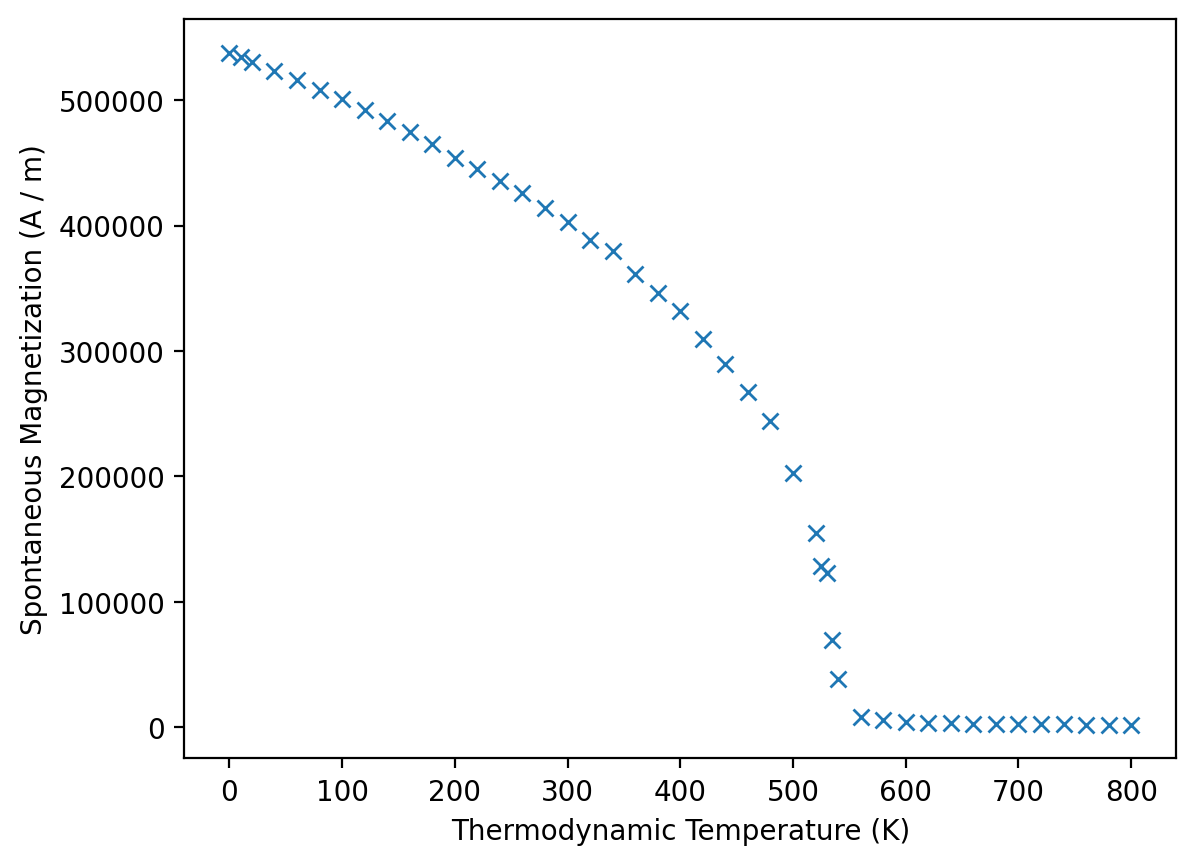

In [8]:
results_spindynamics.plot();

We can access `T` and `Ms` and get `mammos_entity.Entity` objects:

In [9]:
results_spindynamics.T

Entity(ontology_label='ThermodynamicTemperature', value=array([  0.,  10.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180.,
       200., 220., 240., 260., 280., 300., 320., 340., 360., 380., 400.,
       420., 440., 460., 480., 500., 520., 525., 530., 535., 540., 560.,
       580., 600., 620., 640., 660., 680., 700., 720., 740., 760., 780.,
       800.]), unit='K')

In [10]:
results_spindynamics.Ms

Entity(ontology_label='SpontaneousMagnetization', value=array([537694.07444336, 534210.10153311, 530764.36752639, 523250.14178896,
       515738.21821309, 508258.87022332, 500540.39671216, 492131.18264609,
       483755.61631564, 474766.62259313, 465115.79688732, 454004.77916792,
       445207.47657222, 435913.90029753, 425917.95755204, 414302.25010872,
       402869.23234052, 388787.20606118, 379379.38008579, 361089.6076117 ,
       346183.4601142 , 331512.12322956, 309325.38617621, 289791.026683  ,
       267567.34750083, 244087.28601035, 203117.830414  , 154867.46065703,
       128531.95780149, 123413.79484906,  69795.21779487,  38606.54426671,
         8527.81909467,   5671.83537323,   4545.6331974 ,   3692.62583725,
         3234.4405333 ,   2939.70207986,   2710.10548472,   2571.55219002,
         2332.28679587,   2289.83246349,   2162.04656916,   2067.34541027,
         2000.64899435]), unit='A / m')

We can get also the data in the form of a `pandas.DataFrame`, which only contains the values in SI units:

In [11]:
results_spindynamics.dataframe.head()

,T,Ms
0,0.0,537694.074443
1,10.0,534210.101533
2,20.0,530764.367526
3,40.0,523250.141789
4,60.0,515738.218213


## Calculate micromagnetic intrinsic properties using Kuz’min formula

- We use Kuz’min equations to compute Ms(T), A(T), K1(T)
- Kuz’min, M.D., Skokov, K.P., Diop, L.B. et al. Exchange stiffness of ferromagnets. Eur. Phys. J. Plus 135, 301 (2020). https://doi.org/10.1140/epjp/s13360-020-00294-y
- Additional details about inputs and outputs are available in the [API reference](https://mammos-project.github.io/mammos/api/mammos_analysis.kuzmin.html#mammos_analysis.kuzmin.kuzmin_formula)

In [12]:
results_kuzmin = mammos_analysis.kuzmin_properties(
    T=results_spindynamics.T,
    Ms=results_spindynamics.Ms,
    K1_0=results_dft.Ku_0,
)

The `plot` method of the returned object can be used to visualize temperature-dependence of all three quantities. The temperature range matches that of the fit data:

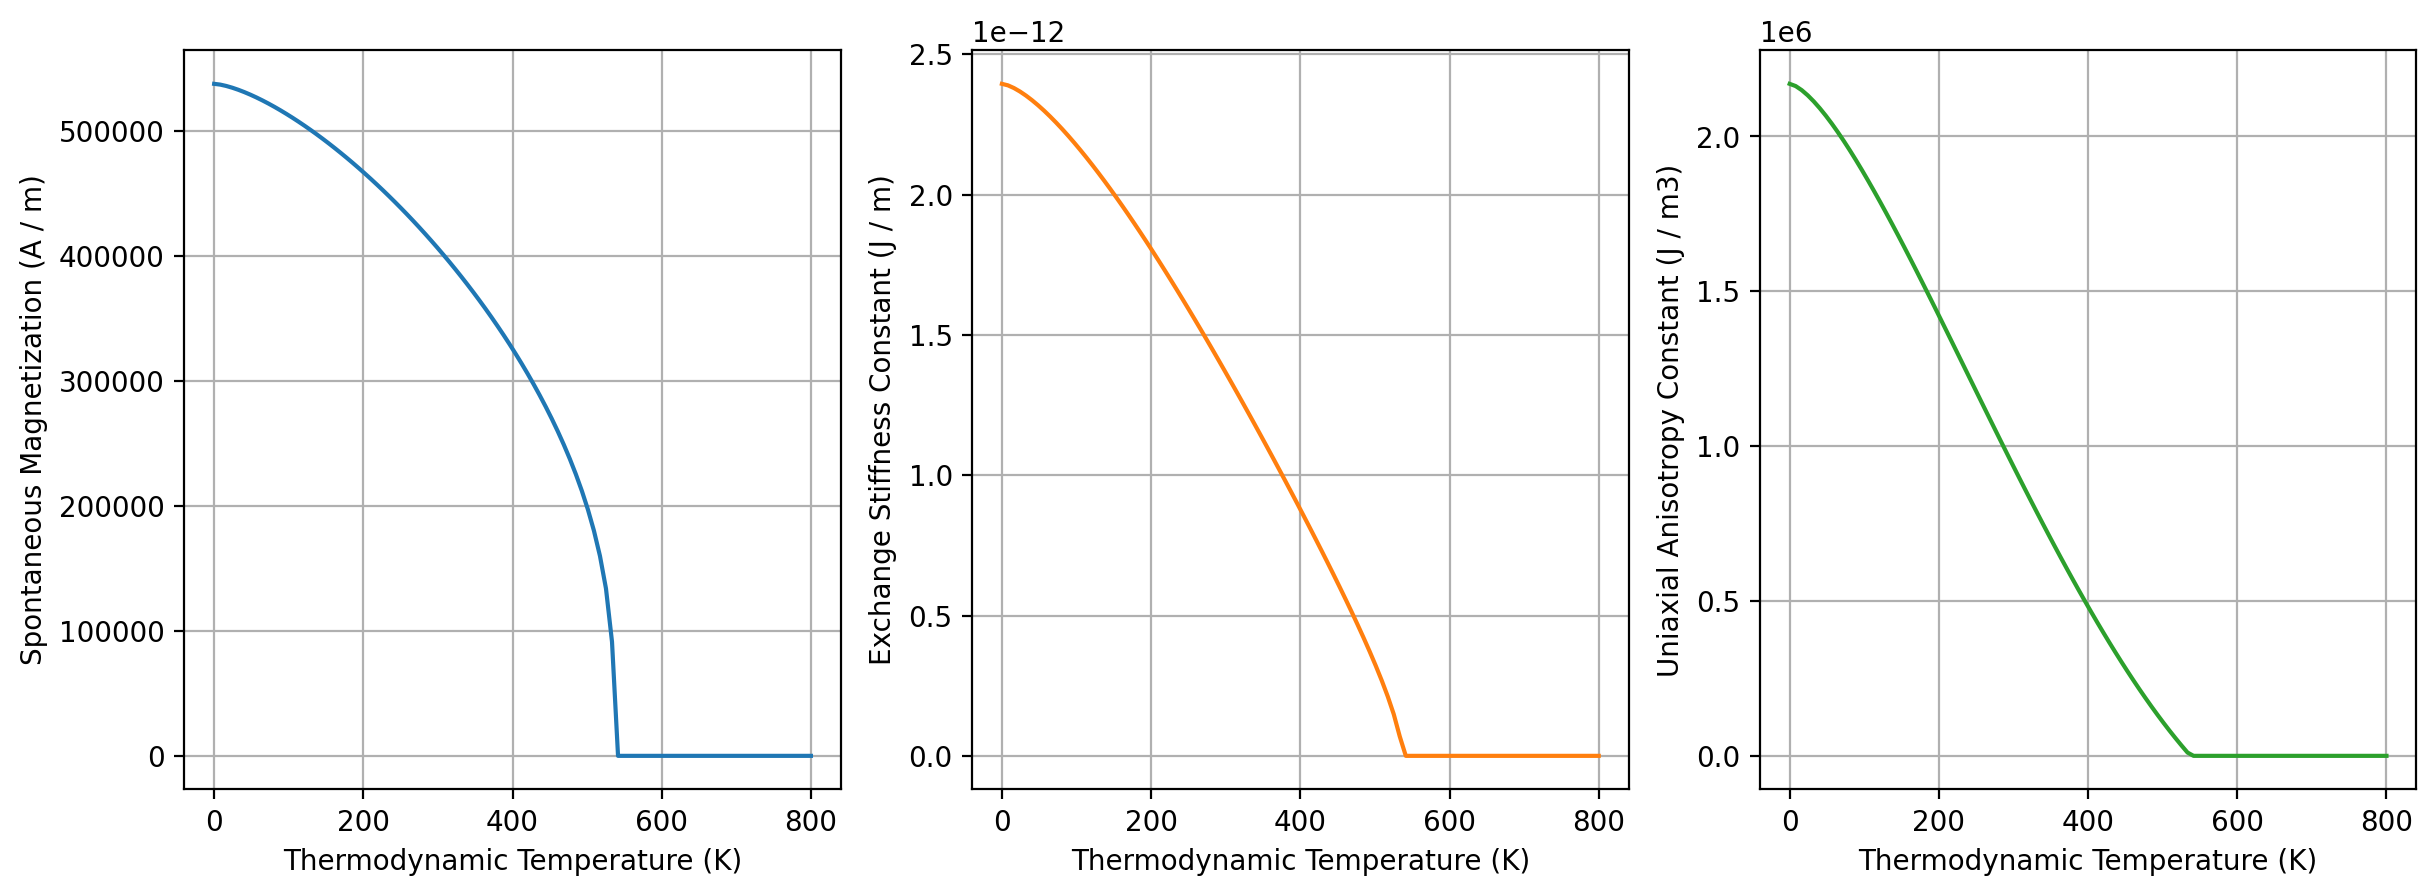

In [13]:
results_kuzmin.plot();

In [14]:
results_kuzmin

KuzminResult(Ms=Ms(T), A=A(T), Tc=Entity(ontology_label='CurieTemperature', value=537.188901303706, unit='K'), s=<Quantity 1.82478202>, K1=K1(T))

- The attributes `Ms`, `A` and `K1` provide fit results as function of temperature. They each have a `plot` method.
- `Tc` is the fitted Curie temperature.
- `s` is a fit parameter in the Kuzmin equation.

To visually assess the accuracy of the fit, we can combine the `plot` methods of `results_kuzmin.Ms` and `results_spindynamics`:

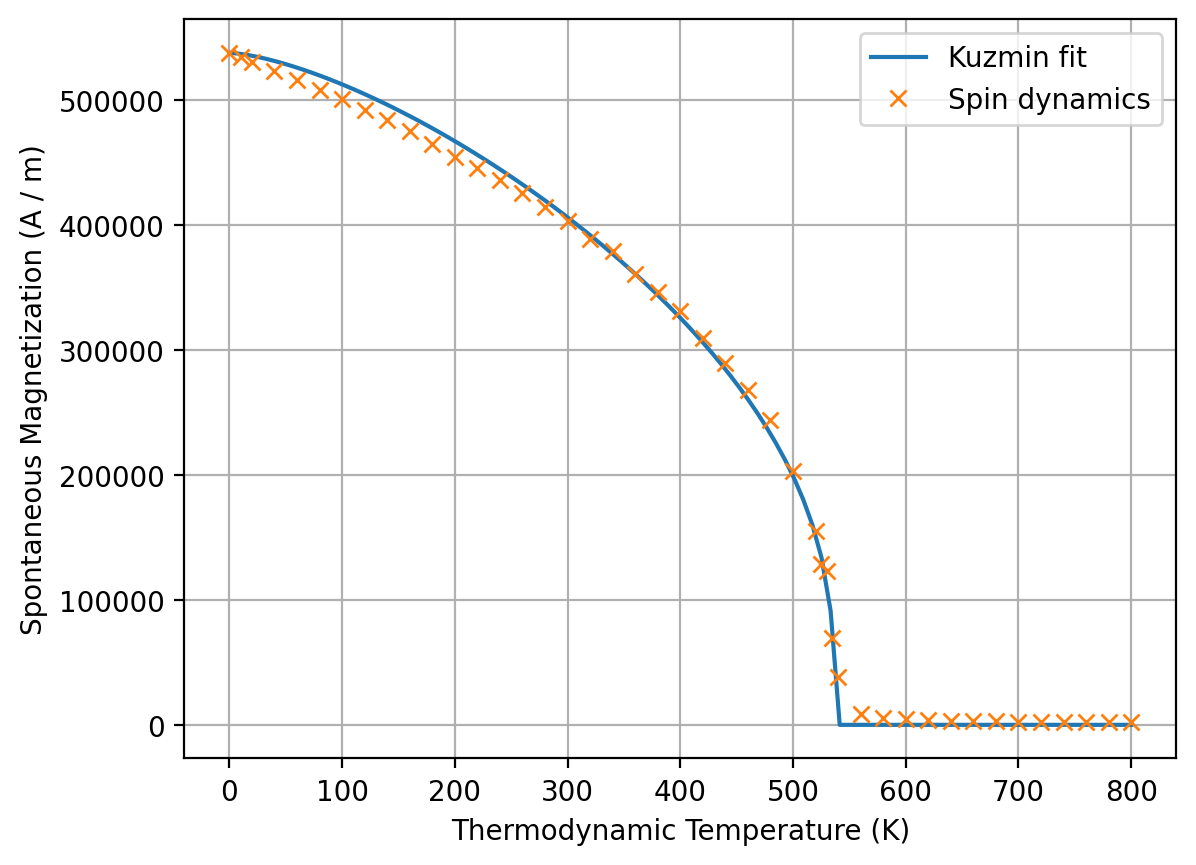

In [15]:
ax = results_kuzmin.Ms.plot(label="Kuzmin fit")
results_spindynamics.plot(ax=ax, label="Spin dynamics");

To get inputs for the micromagnetic simulation at a specific temperature we call the three attributes `Ms`, `A` and `K1`. We can pass a `mammos_entity.Entity`, an `astropy.units.Quantity` or a number:

In [16]:
temperature = me.T(300)
temperature

Entity(ontology_label='ThermodynamicTemperature', value=300.0, unit='K')

In [17]:
results_kuzmin.Ms(temperature)  # Evaluation with Entity

Entity(ontology_label='SpontaneousMagnetization', value=406055.1738027195, unit='A / m')

In [18]:
results_kuzmin.A(300 * u.K)  # Evaluation with Quantity

Entity(ontology_label='ExchangeStiffnessConstant', value=1.3655949176734061e-12, unit='J / m')

In [19]:
results_kuzmin.K1(300)  # Evaluation with number

Entity(ontology_label='UniaxialAnisotropyConstant', value=934564.1726832459, unit='J / m3')

## Run micromagnetic simulation to compute hysteresis loop
- We now compute a hysteresis loop (using a finite-element micromagnetic simulation) with the material parameters we have obtained.
- We simulate a 20x20x20 nm cube for which a pre-defined mesh is available.
- Additional documentation of this step is available [this notebook](https://mammos-project.github.io/mammos/examples/mammos-mumag/quickstart.html).

In [20]:
results_hysteresis = mammos_mumag.hysteresis.run(
    mesh="cube20_singlegrain_msize2",
    Ms=results_kuzmin.Ms(temperature),
    A=results_kuzmin.A(temperature),
    K1=results_kuzmin.K1(temperature),
    theta=0,
    phi=0,
    h_start=(5 * u.T).to(u.A / u.m),
    h_final=(-5 * u.T).to(u.A / u.m),
    h_n_steps=30,
)

The returned `results_hysteresis` object provides a `plot` method to visualize the computed data. `mammos_mumag.hysteresis` only computes half a hysteresis loop, going from `h_start` to `h_final`. To show a full loop this function mirrors the computed data and plots it twice:

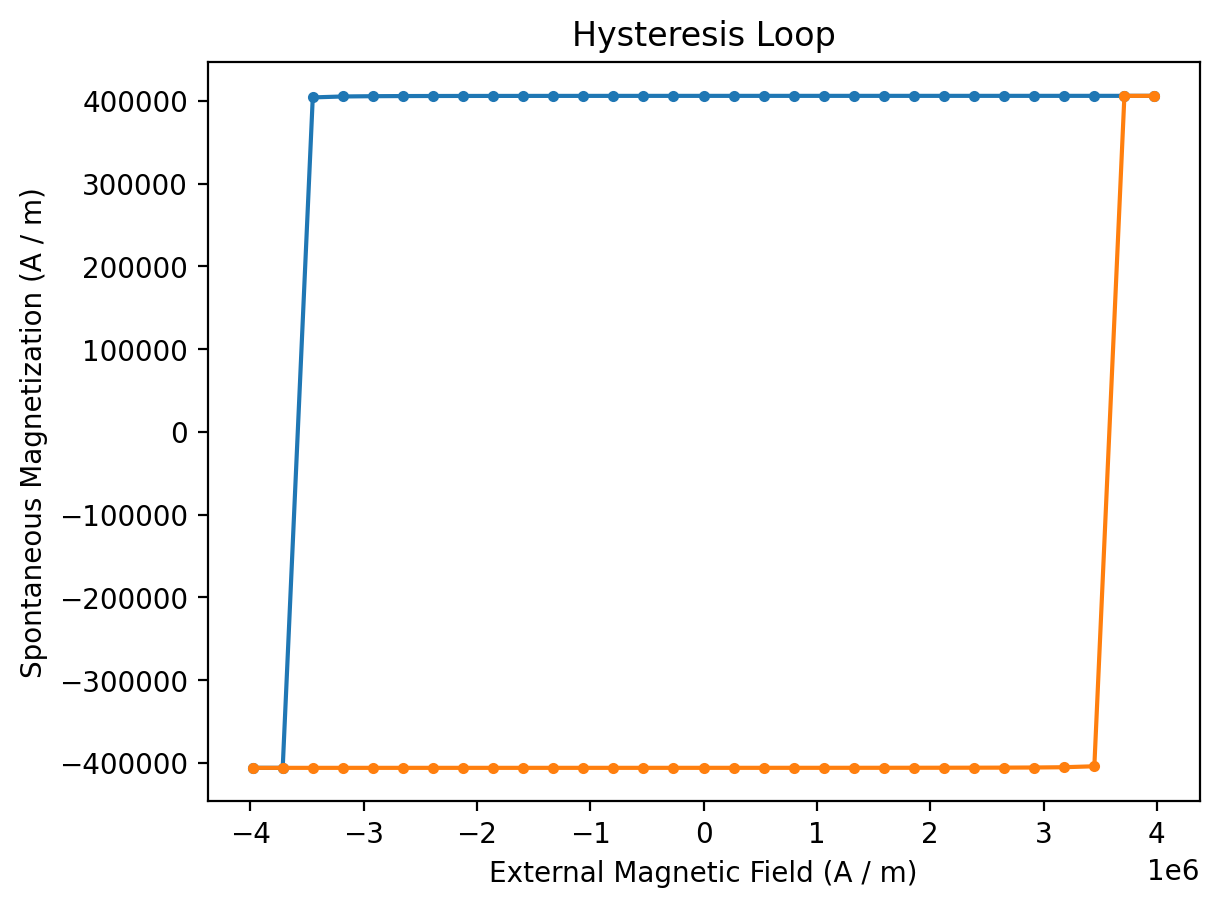

In [21]:
results_hysteresis.plot(marker=".");  # blue: simulation output, orange: mirrored data

The result object provides access to `H` and `M`:

In [22]:
results_hysteresis.H

Entity(ontology_label='ExternalMagneticField', value=array([ 3.97887358e+06,  3.71361534e+06,  3.44835710e+06,  3.18309886e+06,
        2.91784062e+06,  2.65258238e+06,  2.38732415e+06,  2.12206591e+06,
        1.85680767e+06,  1.59154943e+06,  1.32629119e+06,  1.06103295e+06,
        7.95774715e+05,  5.30516477e+05,  2.65258238e+05,  2.65046223e-10,
       -2.65258238e+05, -5.30516477e+05, -7.95774715e+05, -1.06103295e+06,
       -1.32629119e+06, -1.59154943e+06, -1.85680767e+06, -2.12206591e+06,
       -2.38732415e+06, -2.65258238e+06, -2.91784062e+06, -3.18309886e+06,
       -3.44835710e+06, -3.71361534e+06, -3.97887358e+06]), unit='A / m')

In [23]:
results_hysteresis.M

Entity(ontology_label='SpontaneousMagnetization', value=array([ 406047.44159745,  406046.90426802,  406046.30879904,
        406045.6464817 ,  406044.90690923,  406044.07755453,
        406043.14326475,  406042.08550617,  406040.88148894,
        406039.50289286,  406037.91417839,  406036.07025859,
        406033.91328961,  406031.36796102,  406028.33484782,
        406024.68045796,  406020.22216639,  406014.70476192,
        406007.76271805,  405998.85744887,  405987.16834325,
        405971.39428075,  405949.36964165,  405917.26558925,
        405867.76807885,  405785.37766127,  405632.01099909,
        405289.1639208 ,  404149.86394112, -406046.90415708,
       -406047.4416274 ]), unit='A / m')

The `dataframe` property generates a dataframe in the SI units.

In [24]:
results_hysteresis.dataframe.head()

,configuration_type,H,M,Mx,My,Mz,energy_density
0,1,3.978874e+06,406047.441597,-4.121685,-8.621428,406047.441597,-2.933988e+06
1,1,3.713615e+06,406046.904268,-4.270307,-8.929829,406046.904268,-2.798639e+06
2,1,3.448357e+06,406046.308799,-4.430019,-9.260932,406046.308799,-2.663290e+06
3,1,3.183099e+06,406045.646482,-4.602162,-9.617559,406045.646482,-2.527941e+06
4,1,2.917841e+06,406044.906909,-4.788244,-10.002778,406044.906909,-2.392593e+06


We can generate a table in alternate units:

In [25]:
df = pd.DataFrame(
    {
        "mu0_H": results_hysteresis.H.q.to(u.T),
        "J": results_hysteresis.M.q.to(u.T),
    },
)
df.head()

,mu0_H,J
0,5.000000,0.510254
1,4.666667,0.510254
2,4.333333,0.510253
3,4.000000,0.510252
4,3.666667,0.510251


### Plotting of magnetization configurations

Simulation stores specific magnetization field configurations:

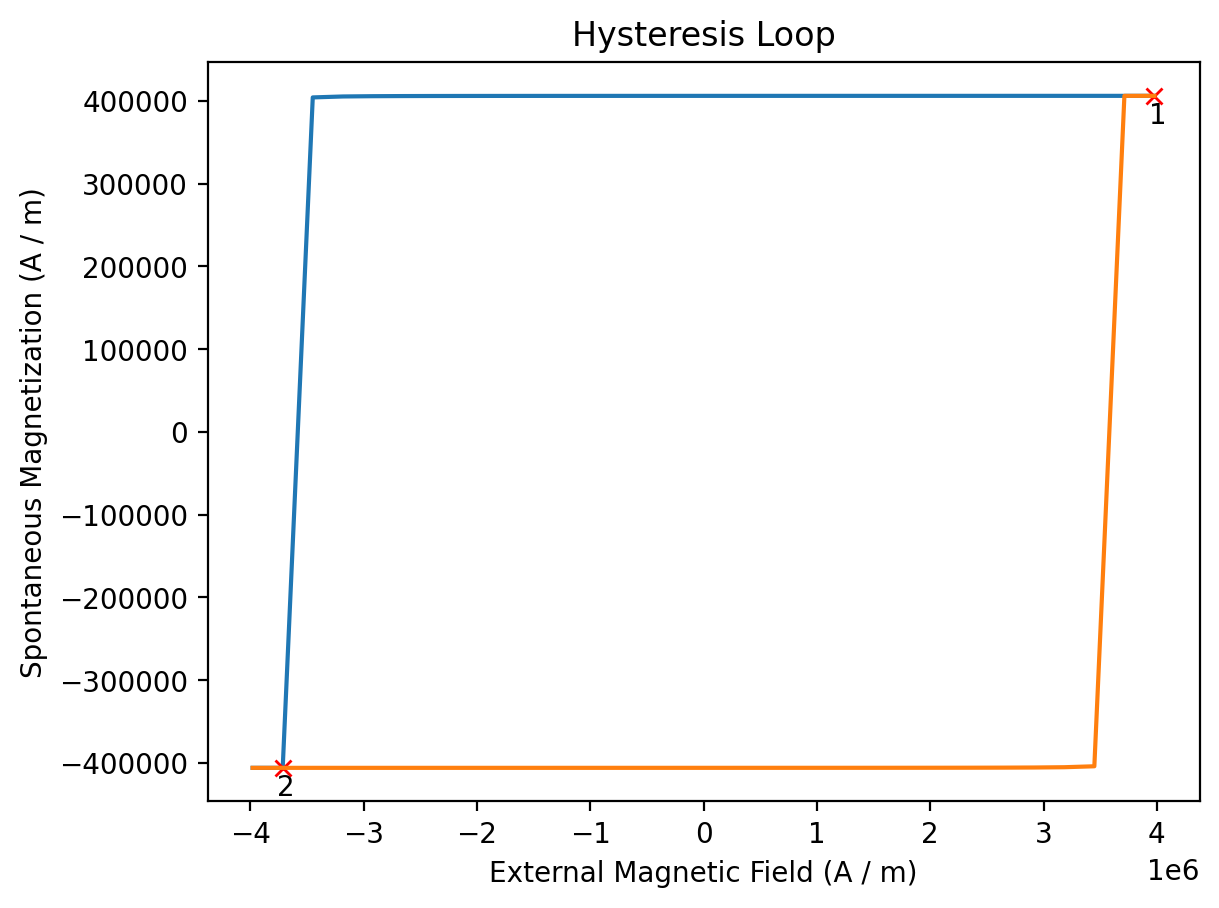

In [26]:
results_hysteresis.plot(configuration_marks=True);

In [27]:
results_hysteresis.configurations

{1: PosixPath('/home/petrocch/repo/mammos/mammos/examples/hystloop/hystloop_0001.vtu'),
 2: PosixPath('/home/petrocch/repo/mammos/mammos/examples/hystloop/hystloop_0002.vtu')}

In [28]:
# results_hysteresis.plot_configuration(1);

## Analyze hysteresis loop
We can extract extrinsic properties with the `extrinsic_properties` function from the `mammos_analysis` package:

In [29]:
extrinsic_properties = mammos_analysis.hysteresis.extrinsic_properties(
    results_hysteresis.H,
    results_hysteresis.M,
    demagnetization_coefficient=1 / 3,
)

In [30]:
extrinsic_properties.Hc

Entity(ontology_label='CoercivityHcExternal', value=3580675.6723497584, unit='A / m')

In [31]:
extrinsic_properties.Mr

Entity(ontology_label='Remanence', value=406024.68045796105, unit='A / m')

In [32]:
extrinsic_properties.BHmax

Entity(ontology_label='MaximumEnergyProduct', value=1807.303256278681, unit='A T / m')

We can combine the `results_hysteresis.plot` method with some custom code to show Hc and Mr in the hysteresis plot:

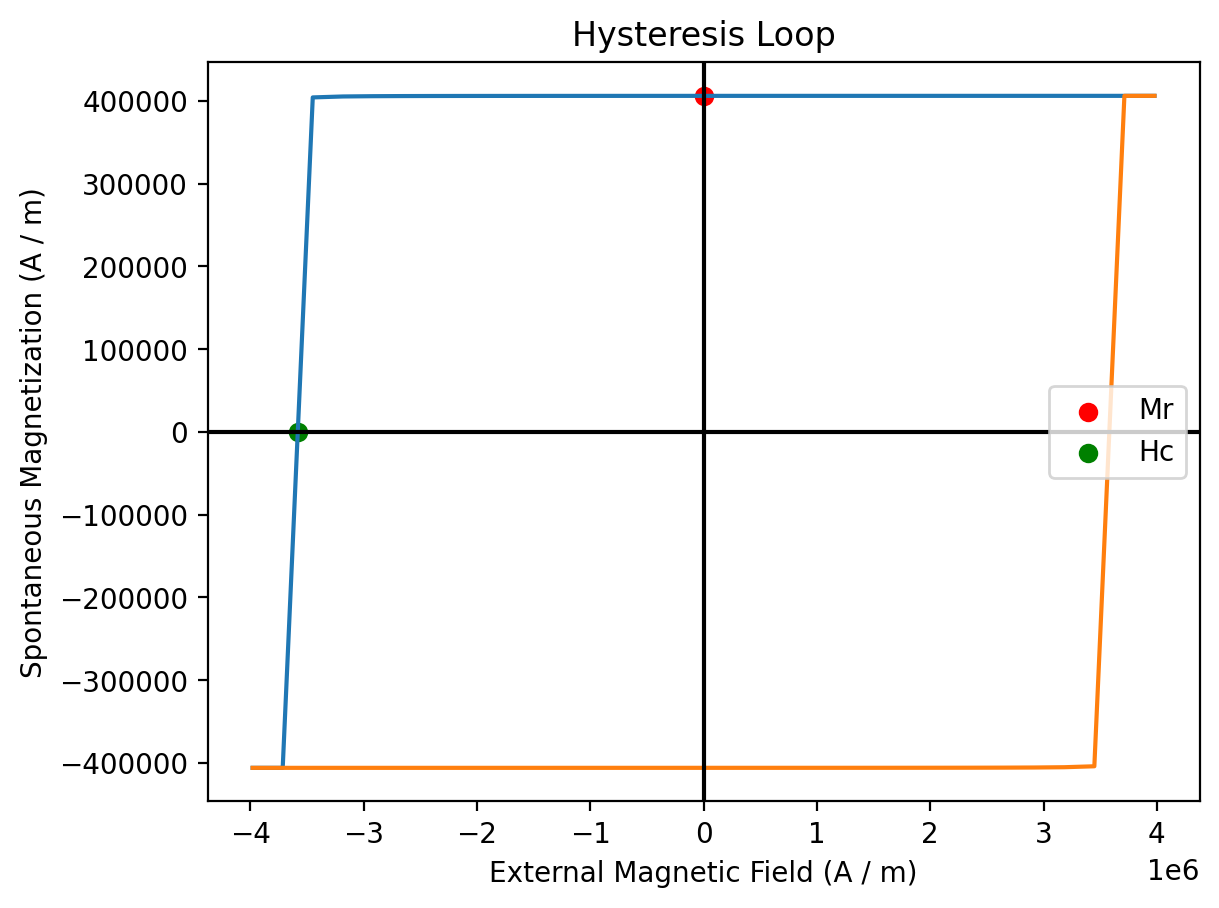

In [33]:
ax = results_hysteresis.plot()
ax.scatter(0, extrinsic_properties.Mr.value, c="r", label="Mr")
ax.scatter(-extrinsic_properties.Hc.value, 0, c="g", label="Hc")
ax.axhline(0, c="k")  # Horizontal line at M=0
ax.axvline(0, c="k")  # Vertical line at H=0
ax.legend();

## Compute Hc(T)

We can leverage mammos to calculate Hc(T) for multiple values of T.

First, we run hysteresis simulations at 7 different temperatures and collect all simulation results:

In [34]:
T = np.linspace(0, 1.1 * results_kuzmin.Tc.q, 7)

simulations = []
for temperature in T:
    print(f"Running simulation for T={temperature:.0f}")
    results_hysteresis = mammos_mumag.hysteresis.run(
        mesh="cube20_singlegrain_msize2",
        Ms=results_kuzmin.Ms(temperature),
        A=results_kuzmin.A(temperature),
        K1=results_kuzmin.K1(temperature),
        theta=0,
        phi=0,
        h_start=(9 * u.T).to(u.A / u.m),
        h_final=(-9 * u.T).to(u.A / u.m),
        h_n_steps=30,
    )
    simulations.append(results_hysteresis)

Running simulation for T=0 K
Running simulation for T=98 K
Running simulation for T=197 K
Running simulation for T=295 K
Running simulation for T=394 K
Running simulation for T=492 K
Running simulation for T=591 K


We can now use `mammos_analysis.hysteresis` as shown before to extract Hc for all simulations and visualize Hc(T):

In [35]:
Hcs = []
for res in simulations:
    cf = mammos_analysis.hysteresis.extract_coercive_field(H=res.H, M=res.M).value
    if np.isnan(cf):  # Above Tc
        cf = 0
    Hcs.append(cf)

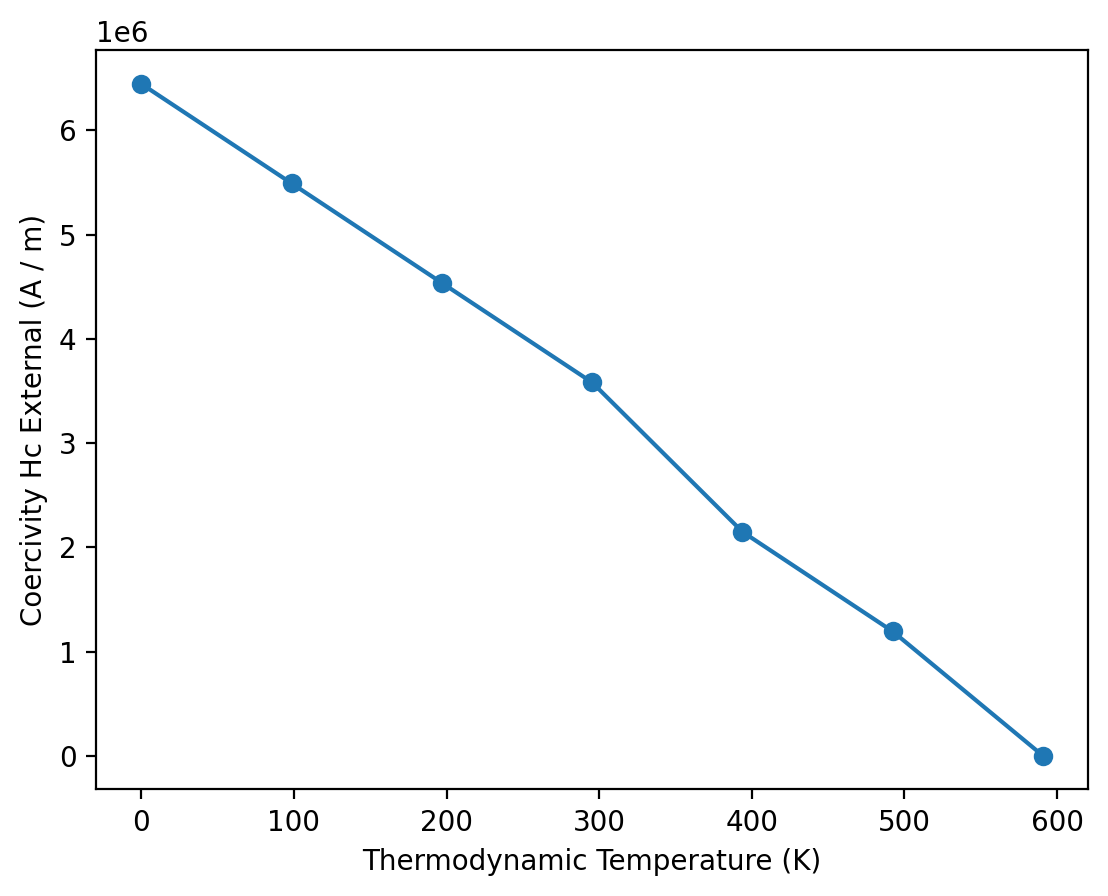

In [36]:
plt.plot(T, Hcs, linestyle="-", marker="o")
plt.xlabel(me.T().axis_label)
plt.ylabel(me.Hc().axis_label);

We can also show the hysteresis loops of all simulations:

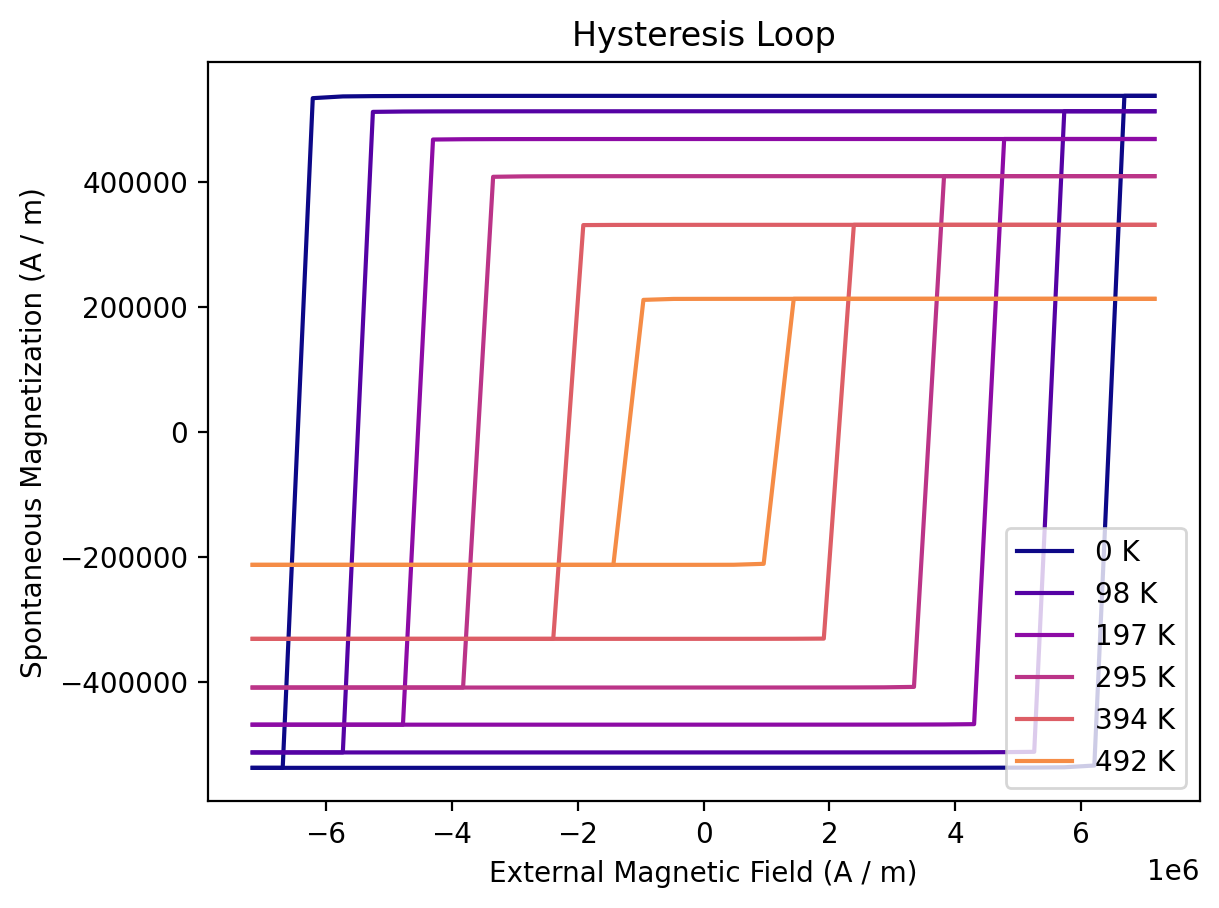

In [37]:
colors = colormaps["plasma"].colors[:: math.ceil(256 / len(T))]

fix, ax = plt.subplots()
for temperature, sim, color in zip(T, simulations, colors, strict=False):
    if np.isnan(sim.M.q).all():  # no Ms above Tc
        continue
    sim.plot(ax=ax, label=f"{temperature:.0f}", color=color, duplicate_change_color=False)
ax.legend(loc="lower right");

## MODA for the workflow
![MODA](images/hard_magnet_workflow.svg)